Camera Calibration with OpenCV
===
Performs camera distortion calibration and perspective warp transform calculations.
Run All Cells should work.  The  Main distortion cell invokes the calibration and runs undistort on the cal input files and displays and saves them to file.


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
import pickle

In [3]:
%%HTML
<style> code {background-color : orange !important;} </style>
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# For debug only. These are default to false at start of module
g_doDrawCorners=True # This is used in cal calculation: Overlays the calImage with the found corners
g_doCreateBothImage = True # Creates composite of input and output images in CameraCal_Undistort()

g_CameraDistortionCalValsFileName = "CameraDistortionCalVals.pypickle"
g_CameraPerspectiveWarpMatrixFileName = "CameraPerspectiveWarpMatrix.pypickle"


In [5]:
def OpenImages(imgFileNames):
    imgList = []
    for imgFileName in imgFileNames:
        img = mpimg.imread(imgFileName)
        imgList.append(img)
    return(imgList)

def SaveImages(imgFileNames, images):
    for imgFileName, img in zip(imgFileNames, images):
        mpimg.imsave(imgFileName, img, format='jpg')

In [6]:
def DrawText(img, text, posLL = (10,40)):
    font                   = cv2.FONT_HERSHEY_PLAIN    
    fontScale              = 2
    fontColor              = (255, 0, 0) # cv.BGR Blue but saved np.RGB red
    lineType               = 2
    cv2.putText(img, text, posLL, font, fontScale, fontColor, lineType)
 

In [7]:
def AnimateImages(imgList, pauseMs=1000):
    for index, imgIn in enumerate(imgList):
        windowName = "img" # 'img'+str(index), imgIn) # Use same window name to reuse same window. Different names for different windows
        cv2.imshow(windowName, imgIn)
        cv2.waitKey(pauseMs)

    cv2.destroyAllWindows()

In [8]:
def CameraCal_FindCorners(calImages, numCornersXY):
    """
    Calculates the chessboard trueCorners and foundCorners of a list of chessboard cal images.
    """
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    numCornersTotal = numCornersXY[0] * numCornersXY[1]
    trueCornerPointsSingle = np.zeros((numCornersTotal, 3), np.float32)
    trueCornerPointsSingle[:,:2] = np.mgrid[0:numCornersXY[0], 0:numCornersXY[1]].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    trueCornerPoints = [] # 3d points in real world space
    foundCornerPoints = [] # 2d points in image plane.

    cornersFoundStatus = []

    # Step through the list and search for chessboard corners
    for index, imgCalIn in enumerate(calImages):
        imgGray = cv2.cvtColor(imgCalIn, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        cornersFound, curImgCornerPoints = cv2.findChessboardCorners(imgGray, numCornersXY, None)
        cornersFoundStatus.append(cornersFound)
        
        print("calImageIndex={} cornersFound={}".format(index+1, cornersFound))
        # If found, append the true and found corners to retval lists
        if cornersFound == True:
            trueCornerPoints.append(trueCornerPointsSingle)
            foundCornerPoints.append(curImgCornerPoints)
            
            # For dev/debug draw the corners on the input image
            if (g_doDrawCorners):
                cv2.drawChessboardCorners(imgCalIn, numCornersXY, curImgCornerPoints, True) 

        # For dev/debug draw failure notice input image        
        elif (g_doDrawCorners):
            DrawText(imgCalIn, 'CornersNotFound!')            
        
    return(cornersFoundStatus, trueCornerPoints, foundCornerPoints)

In [9]:
def CameraCal_CalcCalValsFromPoints(trueCornerPoints, foundCornerPoints, imgSample):
    """
    Do camera calibration given object points and image points
    """
    
    imgSize = (imgSample.shape[1], imgSample.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(trueCornerPoints, foundCornerPoints, imgSize, None, None)
    dictCameraCalVals = {}
    dictCameraCalVals["mtx"] = mtx
    dictCameraCalVals["dist"] = dist
    dictCameraCalVals["rvecs"] = rvecs
    dictCameraCalVals["tvecs"] = tvecs
    return(dictCameraCalVals)

def CameraCal_CalcCalValsFromImages(calImages, numCornersXY):
    """
    Do camera calibration given a list of numpy checkerboard images
    """
    
    cornersFoundStatus, trueCornerPoints, foundCornerPoints = CameraCal_FindCorners(calImages, numCornersXY)
    dictCameraCalVals = CameraCal_CalcCalValsFromPoints(trueCornerPoints, foundCornerPoints, calImages[0])
    return(dictCameraCalVals)
 
def CameraCal_SaveCalFile(calFileName, dictCameraCalVals):
    pickle.dump(dictCameraCalVals, open(calFileName, "wb" ) )

def CameraCal_LoadCalFile(calFileName):
    dictCameraCalVals = pickle.load( open(calFileName, "rb" ) )
    return(dictCameraCalVals)
    

In [10]:
def CameraCal_Undistort(dictCameraCalVals, imgIn):
    """
    Perform image undistortion on a numpy image
    """
    imgOut = cv2.undistort(imgIn, dictCameraCalVals["mtx"], dictCameraCalVals["dist"], None, dictCameraCalVals["mtx"])
    return(imgOut)

def CameraCal_UndistortList(dictCameraCalVals, imagesIn):
    """
    Perform image undistortion on a list of numpy images
    """
    imagesOut = []
    imagesBothOut = []
    for index, imgIn in enumerate(imagesIn):
        imgOut = CameraCal_Undistort(dictCameraCalVals, imgIn)
        imagesOut.append(imgOut)        
        if (g_doCreateBothImage):
            imgBoth = np.concatenate((imgIn, imgOut), axis=1)
            imagesBothOut.append(imgBoth)        
    return(imagesBothOut, imagesOut)

## Main routine for distortion calibration
### Creates a camera distortion cal object from a list of checkerboard cal files and saves the cal object to disk
Or optionally loads the cal object from disk.
Then applies the cal object to test images and displays (and optionally saves) the resulting images

In [10]:
def CameraCal_DoDistortionCal():
    numCornersXY = (9,6)
    calFileInNames = glob.glob('camera_cal/cal*.jpg')
    #calFileInNames = ['camera_cal/calibration2.jpg']
    outputDir = "camera_caloutput/"

    # Get natural sort of files... only works for this exact environment and is useful only for dev debug
    doSort=True
    if (doSort):
        baseLen = len("camera_cal/calibration")
        calFileInNames = sorted(calFileInNames, key=lambda fileName: int(fileName[baseLen:-4]))
    else:
        calFileInNames

    #print("Infiles: ", calFileInNames)
    calImages = OpenImages(calFileInNames)

    if (not os.path.exists(outputDir)):
        os.makedirs(g_outputDir)
        
    useCalFile = False
    if (useCalFile):
        dictCameraCalVals = CameraCal_LoadCalFile(g_CameraDistortionCalValsFileName)
    else:
        dictCameraCalVals = CameraCal_CalcCalValsFromImages(calImages, numCornersXY)
        CameraCal_SaveCalFile(g_CameraDistortionCalValsFileName, dictCameraCalVals)
        #AnimateImages(g_calImages, 2000)

    # Run undistort test on the same images used for calibration
    testImagesIn = calImages
    testImagesBothOut, testImagesOut = CameraCal_UndistortList(dictCameraCalVals, testImagesIn)  

    # Animate the combined test output to see side by side comparison
    AnimateImages(testImagesBothOut, 500)

    saveOutFiles = True
    if (saveOutFiles):
        outputFileNames = [(outputDir + os.path.splitext(os.path.basename(fileName))[0] + ".out.jpg") for fileName in calFileInNames]
        #print("Outfiles: ", g_outputFileNames)
        SaveImages(outputFileNames, testImagesBothOut)

        
print("UNCOMMENT INVOCATION!!!")
CameraCal_DoDistortionCal()

UNCOMMENT INVOCATION!!!
calImageIndex=1 cornersFound=False
calImageIndex=2 cornersFound=True
calImageIndex=3 cornersFound=True
calImageIndex=4 cornersFound=False
calImageIndex=5 cornersFound=False
calImageIndex=6 cornersFound=True
calImageIndex=7 cornersFound=True
calImageIndex=8 cornersFound=True
calImageIndex=9 cornersFound=True
calImageIndex=10 cornersFound=True
calImageIndex=11 cornersFound=True
calImageIndex=12 cornersFound=True
calImageIndex=13 cornersFound=True
calImageIndex=14 cornersFound=True
calImageIndex=15 cornersFound=True
calImageIndex=16 cornersFound=True
calImageIndex=17 cornersFound=True
calImageIndex=18 cornersFound=True
calImageIndex=19 cornersFound=True
calImageIndex=20 cornersFound=True


## Sample invocation  of Undistort for use in image proc pipeline

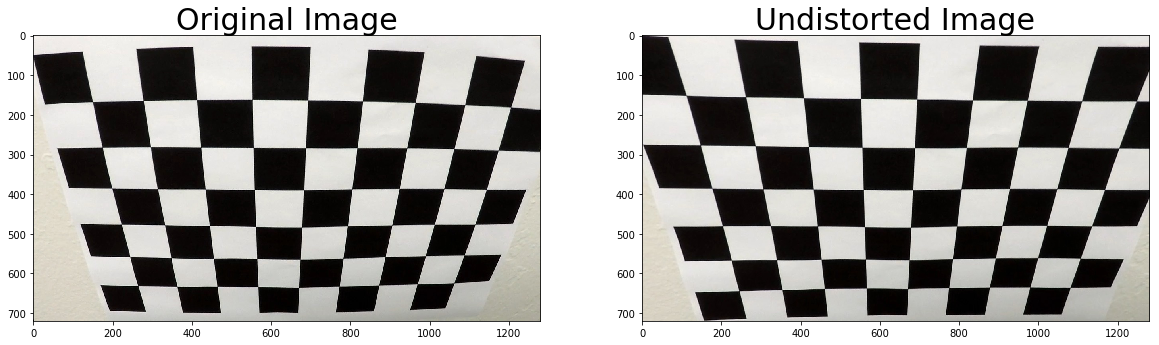

In [11]:
def SampleInvocationUndistort():
    imgFileName = 'camera_cal/calibration2.jpg'
    imgIn = mpimg.imread(imgFileName)

    dictCameraCalVals = CameraCal_LoadCalFile(g_CameraDistortionCalValsFileName)
    imgUndistorted = CameraCal_Undistort(dictCameraCalVals, imgIn)
    
    %matplotlib inline  
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(imgIn)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(imgUndistorted)
    ax2.set_title('Undistorted Image', fontsize=30)
    
SampleInvocationUndistort()

## Perspective Warp Calibration section

In [12]:
def GetPerspectiveWarpTrapezoids():
    """
    Returns the src and dest trapezoids used by GetPerspectiveWarpTransform/cv2.getPerspectiveTransform
    """
    # Define the location of points of the trapezoid
    # as seen in the POV image. These are determined empirically
    # by manually selecting the pixel points in the calibration image
    # in EmpiricalWarpTrapazoidTool()
    
    # 4 [X,Y] coords from the TopLeft CounterClockWise: LeftTop LeftBottom, RightBottom, RightTop
    srcTrap = np.float32([
                     [580, 460], # LT
                     [213, 718], # LB
                     [1103, 718],# RB
                     [705, 460]])# RT
 
    # Temp vals for readability    
    (srcLT, srcLB, srcRB, srcRT)  = srcTrap

    # Define the location to where each those points will map to
    # in the destination image. Move the bottoms in, and the tops out, 
    destL= (srcLT[0] + srcLB[0])/2 - 100
    destR= (srcRT[0] + srcRB[0])/2 + 100
    destT= 0
    destB= 715

    # Define the points of the destination image to which the src trapezoid point should map to
    destRect = np.float32([
                     [destL, destT],  # LT
                     [destL, destB],  # LB
                     [destR, destB],  # RB
                     [destR, destT],])# RT

    #print("Dest L={} R={} T={} B={}".format(destL, destR, destT, destB))
    #print("dstRect",destRect)
    return(srcTrap, destRect)


def GetPerspectiveWarpTransform():
    """ 
    Calculation of perspective warp transform matrix
    Retrieves the srcTrapezoid and destRectangles that have been empirically tuned
    Returns a transform matrix to be called by cv2.warpPerspective
    """
    (srcTrap, destRect) = GetPerspectiveWarpTrapezoids()
    matrix = cv2.getPerspectiveTransform(srcTrap, destRect)
    return matrix

#INTER_NEAREST - a nearest-neighbor interpolation
#INTER_LINEAR - a bilinear interpolation (used by default)
#INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
#INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
#INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

def DoPerspectiveTransform(imgIn, matTransform):
    img_size = (imgIn.shape[1], imgIn.shape[0])
    interpolation = cv2.INTER_CUBIC
    imgWarped = cv2.warpPerspective(imgIn, matTransform, img_size, flags=interpolation)
    return imgWarped


In [13]:
def CameraCal_SaveWarpFile(fileName, warpMatrix):
    pickle.dump(warpMatrix, open(fileName, "wb" ) )

def CameraCal_LoadWarpFile(fileName):
    warpMatrix = pickle.load( open(fileName, "rb" ) )
    return(warpMatrix)

def CalcAndSaveWarpFile():
    matPerspectiveWarp = GetPerspectiveWarpTransform()
    CameraCal_SaveWarpFile(g_CameraPerspectiveWarpMatrixFileName, matPerspectiveWarp)
    
CalcAndSaveWarpFile()

In [15]:
def SampleInvocationPerspectiveWarp():
    imgInFileName = 'test_images/straight_lines2.jpg'
    #imgInFileName = 'test_images/straight_lines2.jpg'
    imgInFileName = 'camera_caloutput/straight_lines1.warptrap.jpg'
    imgInFileName = 'camera_caloutput/straight_lines2.warptrap.jpg'
    imgIn = mpimg.imread(imgInFileName)
    
    dictCameraCalVals = CameraCal_LoadCalFile(g_CameraDistortionCalValsFileName)
    imgIn = CameraCal_Undistort(dictCameraCalVals, imgIn)

    useCalFile = False
    if (useCalFile):
        matPerspectiveWarp = CameraCal_LoadWarpFile(g_CameraPerspectiveWarpMatrixFileName)
    else:
        matPerspectiveWarp = GetPerspectiveWarpTransform()
        
    imgWarped = DoPerspectiveTransform(imgIn, matPerspectiveWarp)
    
    %matplotlib qt4
    #%matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(imgIn)
    ax1.set_title('imgIn', fontsize=30)
    ax2.imshow(imgWarped)
    ax2.set_title('imgWarped', fontsize=30)
    plt.tight_layout()
    
    imgOutFileName = 'camera_caloutput/straight_lines1.warped.jpg'
    #mpimg.imsave(imgOutFileName, imgWarped, format='jpg')

print("UNCOMMENT INVOCATION!!!")
SampleInvocationPerspectiveWarp()

UNCOMMENT INVOCATION!!!


### Perspective warp tool
This is a dev/debug convenience utility to assist finding appropriate points for perspective warping.
It is an offline/off pipeline calibration step. Once srcTrap has been determined this function is not used.
It also saves the trapzoid overlay for reference in the writeup.
Modification of the actual values is done in GetPerspectiveWarpTrapezoids()

In [15]:
def EmpiricalWarpTrapazoidTool():
    imgIn1FileName = 'test_images/straight_lines1.jpg'
    imgIn1 = mpimg.imread(imgIn1FileName)
    imgIn2FileName = 'test_images/straight_lines2.jpg'
    imgIn2 = mpimg.imread(imgIn2FileName)

    # Do distortion correction. Only makes a couple pixels difference in near field
    dictCameraCalVals = CameraCal_LoadCalFile(g_calFileName)
    imgIn1 = CameraCal_Undistort(dictCameraCalVals, imgIn1)
    imgIn2 = CameraCal_Undistort(dictCameraCalVals, imgIn2)

    (srcTrap, destRect) = GetPerspectiveWarpTrapezoids()
 
    # Convert points that are acceptable to cv2.polylines()
    trapInts = srcTrap.astype(int)
    cvPolyPts = trapInts.reshape((-1,1,2)) # I don't understand this, but it's needed. Thank you internet!
    
    lineThickness = 1
    color = (255,0,0)
    imgOut1 = cv2.polylines(imgIn1, [cvPolyPts], True, color, lineThickness)            
    imgOut2 = cv2.polylines(imgIn2, [cvPolyPts], True, color, lineThickness) 
    
    %matplotlib qt4
    #%matplotlib inline
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(imgOut1)
    ax1.set_title(imgIn1FileName, fontsize=20)
    ax2.imshow(imgOut2)
    ax2.set_title(imgIn2FileName, fontsize=20)
    plt.tight_layout()
    
    imgOut1FileName = 'camera_caloutput/straight_lines1.warptrap.jpg'
    imgOut2FileName = 'camera_caloutput/straight_lines2.warptrap.jpg'
    mpimg.imsave(imgOut1FileName, imgOut1, format='jpg')
    mpimg.imsave(imgOut2FileName, imgOut2, format='jpg')

print("UNCOMMENT INVOCATION!!!")
#=====> Uncomment next line to run the tool
#EmpiricalWarpTrapazoidTool()

UNCOMMENT INVOCATION!!!
